<a href="https://colab.research.google.com/github/mugsiemx/deep-learning-challenge/blob/main/AlphabetSoupCharity_Optimization_extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [1]:
# import the repository for the csv file
! git clone https://github.com/mugsiemx/deep-learning-challenge

Cloning into 'deep-learning-challenge'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 154 (delta 90), reused 54 (delta 30), pack-reused 0
Receiving objects: 100% (154/154), 3.39 MiB | 12.41 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [49]:
# Import our dependencies
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# read the CSV file from the Resources folder into a dask DataFrame
## change the data types to strings and integers
%time df = dd.read_csv('/content/deep-learning-challenge/Resources/charity_data.csv', low_memory=False,\
                       dtype={'APPLICATION_TYPE': 'string','AFFILIATION': 'string','CLASSIFICATION': 'string',\
                              'USE_CASE': 'string','ORGANIZATION': 'string','STATUS': 'int','INCOME_AMT': 'string',\
                              'SPECIAL_CONSIDERATIONS': 'string', 'NAME': 'string'}\
                       )
# review the DataFrame
df.dtypes, df.shape

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 14.1 ms


(EIN                        int64
 NAME                      string
 APPLICATION_TYPE          string
 AFFILIATION               string
 CLASSIFICATION            string
 USE_CASE                  string
 ORGANIZATION              string
 STATUS                     int64
 INCOME_AMT                string
 SPECIAL_CONSIDERATIONS    string
 ASK_AMT                    int64
 IS_SUCCESSFUL              int64
 dtype: object,
 (Delayed('int-7e0bf783-cd0b-4430-8516-fcbfe00c7d73'), 12))

In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
# df = df.drop(['EIN','NAME'], axis=1)

# revisited, dropping only EIN
df = df.drop(['EIN'], axis=1)
df.info(), df.dtypes

<class 'dask.dataframe.core.DataFrame'>
Columns: 11 entries, NAME to IS_SUCCESSFUL
dtypes: int64(3), string(8)

(None,
 NAME                      string
 APPLICATION_TYPE          string
 AFFILIATION               string
 CLASSIFICATION            string
 USE_CASE                  string
 ORGANIZATION              string
 STATUS                     int64
 INCOME_AMT                string
 SPECIAL_CONSIDERATIONS    string
 ASK_AMT                    int64
 IS_SUCCESSFUL              int64
 dtype: object)

In [4]:
# create DataFrame with compute
application_df = df.compute()
application_df

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...,...
34294,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,PTA HAWAII CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


# Analyze individual columns for optimization opportunities

In [ ]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

* NAME

In [5]:
nam_counts = application_df['NAME'].value_counts()
nam_counts

PARENT BOOSTER USA INC                               1260
TOPS CLUB INC                                         765
UNITED STATES BOWLING CONGRESS INC                    700
WASHINGTON STATE UNIVERSITY                           492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC       408
                                                     ... 
POM-POMS CASTLE                                         1
FOUNDATION FOR INTERVENTIONAL RADIOLOGICAL RES...       1
DARE U TO CARE OUTREACH MINISTRY                        1
GEFFEN PLAYHOUSE INC                                    1
WATERHOUSE CHARITABLE TR                                1
Name: NAME, Length: 19568, dtype: Int64

In [6]:
application_df.groupby(['IS_SUCCESSFUL','NAME'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  NAME                                     
0              100 BLACK MEN OF WEST GEORGIA INC            1
               1150 WEBSTER STREET INC                      1
               146TH ALUMNI ASSOCIATION                     1
               1K NATION INC                                1
               2041 FOUNDATION INCORPORATED                 1
                                                           ..
1              ZOZ AMBA FOUNDATION                          1
               ZUMAS RESCUE RANCH INC                       1
               ZUNEN AGRIBUSINESS SOLUTIONS                 1
               ZUNI MOUNTAIN ENVIRONMENTAL ACTION LEAGUE    1
               ZURICH PUBLISHING FOUNDATION INC             1
Name: IS_SUCCESSFUL, Length: 19828, dtype: int64

* APPLICATION_TYPE

In [7]:
app_counts = application_df['APPLICATION_TYPE'].value_counts()
app_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: Int64

In [8]:
application_df.groupby(['IS_SUCCESSFUL','APPLICATION_TYPE'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  APPLICATION_TYPE
0              T10                    64
               T12                     3
               T13                     5
               T19                   864
               T2                      7
               T25                     1
               T3                  12649
               T4                   1071
               T5                    273
               T6                    316
               T7                    315
               T8                    426
               T9                     44
1              T10                   464
               T12                    24
               T13                    61
               T14                     3
               T15                     2
               T17                     1
               T19                   201
               T2                      9
               T25                     2
               T29                     2
               T3        

* AFFILIATION

In [9]:
afl_counts = application_df['AFFILIATION'].value_counts()
afl_counts

Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: Int64

In [10]:
application_df.groupby(['IS_SUCCESSFUL','AFFILIATION'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  AFFILIATION     
0              CompanySponsored    10493
               Family/Parent          28
               Independent          5499
               National               13
               Regional                5
1              CompanySponsored     5212
               Family/Parent          36
               Independent         12981
               National               20
               Other                   4
               Regional                8
Name: IS_SUCCESSFUL, dtype: int64

* CLASSIFICATION

In [11]:
cls_counts = application_df['CLASSIFICATION'].value_counts()
cls_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C5200        1
C2600        1
C4200        1
C2190        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: Int64

In [12]:
application_df.groupby(['IS_SUCCESSFUL','CLASSIFICATION'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  CLASSIFICATION
0              C0                   1
               C1000             7566
               C1200             2599
               C1230                6
               C1236                1
                                 ... 
1              C7200               28
               C7210                7
               C8000               14
               C8200                1
               C8210                1
Name: IS_SUCCESSFUL, Length: 108, dtype: int64

* USE_CASE

In [13]:
use_counts = application_df['USE_CASE'].value_counts()
use_counts

Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other                3
Name: USE_CASE, dtype: Int64

In [14]:
application_df.groupby(['IS_SUCCESSFUL','USE_CASE'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  USE_CASE     
0              CommunityServ      250
               Heathcare           83
               Preservation     12978
               ProductDev        2727
1              CommunityServ      134
               Heathcare           63
               Other                3
               Preservation     15117
               ProductDev        2944
Name: IS_SUCCESSFUL, dtype: int64

* ORGANIZATION

In [15]:
org_counts = application_df['ORGANIZATION'].value_counts()
org_counts

Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: ORGANIZATION, dtype: Int64

In [16]:
application_df.groupby(['IS_SUCCESSFUL','ORGANIZATION'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ORGANIZATION
0              Association      6202
               Co-operative      119
               Corporation        10
               Trust            9707
1              Association      4053
               Co-operative      367
               Corporation        33
               Trust           13808
Name: IS_SUCCESSFUL, dtype: int64

* STATUS

In [17]:
sts_counts = application_df['STATUS'].value_counts()
sts_counts

1    34294
0        5
Name: STATUS, dtype: int64

In [18]:
application_df.groupby(['IS_SUCCESSFUL','STATUS'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  STATUS
0              0             2
               1         16036
1              0             3
               1         18258
Name: IS_SUCCESSFUL, dtype: int64

* INCOME_AMT

In [19]:
inc_counts = application_df['INCOME_AMT'].value_counts()
inc_counts

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: Int64

In [20]:
application_df.groupby(['IS_SUCCESSFUL','INCOME_AMT'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  INCOME_AMT   
0              0                11811
               1-9999             175
               10000-24999        175
               100000-499999     1422
               10M-50M            143
               1M-5M              510
               25000-99999       1612
               50M+                92
               5M-10M              98
1              0                12577
               1-9999             553
               10000-24999        368
               100000-499999     1952
               10M-50M             97
               1M-5M              445
               25000-99999       2135
               50M+                47
               5M-10M              87
Name: IS_SUCCESSFUL, dtype: int64

* SPECIAL_CONSIDERATIONS

In [21]:
spc_counts = application_df['SPECIAL_CONSIDERATIONS'].value_counts()
spc_counts

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: Int64

In [22]:
application_df.groupby(['IS_SUCCESSFUL','SPECIAL_CONSIDERATIONS'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  SPECIAL_CONSIDERATIONS
0              N                         16028
               Y                            10
1              N                         18244
               Y                            17
Name: IS_SUCCESSFUL, dtype: int64

* ASK_AMT

In [23]:
ask_counts = application_df['ASK_AMT'].value_counts()
ask_counts

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [24]:
application_df.groupby(['IS_SUCCESSFUL','ASK_AMT'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ASK_AMT   
0              5000          12095
               5006              2
               5040              1
               5044              1
               5050              1
                             ...  
1              1281905997        1
               1736232349        1
               2310256039        1
               3391919220        1
               8597806340        1
Name: IS_SUCCESSFUL, Length: 8823, dtype: int64


# Create bins for features with a low number of "bucket" counts

---



In [25]:
# NAME - Revise default bins
name_types_to_replace = nam_counts[nam_counts < 100].index.values
    
# # Replace in dataframe
for nam in name_types_to_replace:
    application_df['NAME'] = application_df['NAME'].replace(nam,"Other")

# Check to make sure binning was successful
application_df['NAME'].value_counts()

Other                                                25987
PARENT BOOSTER USA INC                                1260
TOPS CLUB INC                                          765
UNITED STATES BOWLING CONGRESS INC                     700
WASHINGTON STATE UNIVERSITY                            492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC        408
PTA TEXAS CONGRESS                                     368
SOROPTIMIST INTERNATIONAL OF THE AMERICAS INC          331
ALPHA PHI SIGMA                                        313
TOASTMASTERS INTERNATIONAL                             293
MOST WORSHIPFUL STRINGER FREE AND ACCEPTED MASONS      287
LITTLE LEAGUE BASEBALL INC                             277
INTERNATIONAL ASSOCIATION OF LIONS CLUBS               266
MOMS CLUB                                              210
INTERNATIONAL ASSOCIATION OF SHEET METAL AIR R...      206
AMERICAN ASSOCIATION OF UNIVERSITY WOMEN               197
FARMERS EDUCATIONAL AND COOPERATIVE UNION OF A...      1

In [26]:
# APPLICATION_TYPE - Revise default bins
application_types_to_replace = app_counts[app_counts < 500].index.values
    
# # Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: Int64

In [27]:
# # AFFILIATION - Revise default bins
# affiliations_to_replace = afl_counts[afl_counts < 15000].index.values

# # Replace in dataframe
# for afl in affiliations_to_replace:
#     application_df['AFFILIATION'] = application_df['AFFILIATION'].replace(afl,"Other")
    
# # Check to make sure binning was successful
# application_df['AFFILIATION'].value_counts()

In [28]:
# CLASSIFICATION - Revise default bins
classification_to_replace = cls_counts[cls_counts < 100].index.values

# Replace in dataframe
for cls in classification_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
Other      669
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
Name: CLASSIFICATION, dtype: Int64

In [29]:
# USE_CASE - Revise default bins
use_case_to_replace = use_counts[use_counts < 2000].index.values

# Replace in dataframe
for use in use_case_to_replace:
    application_df['USE_CASE'] = application_df['USE_CASE'].replace(use,"Other")
    
# Check to make sure binning was successful
application_df['USE_CASE'].value_counts()

Preservation    28095
ProductDev       5671
Other             533
Name: USE_CASE, dtype: Int64

In [30]:
# ASK_AMT - Revise default bins
application_df['ask_amt_bin'] = pd.qcut(application_df['ASK_AMT'], duplicates='drop', q=10)
application_df.groupby(['IS_SUCCESSFUL','ask_amt_bin'])['IS_SUCCESSFUL'].agg('count')

IS_SUCCESSFUL  ask_amt_bin             
0              (4999.999, 30898.8]         12899
               (30898.8, 196546.2]          1462
               (196546.2, 8597806340.0]     1677
1              (4999.999, 30898.8]         14540
               (30898.8, 196546.2]          1968
               (196546.2, 8597806340.0]     1753
Name: IS_SUCCESSFUL, dtype: int64

In [31]:
application_df['ask_amt_bin'].value_counts()

(4999.999, 30898.8]         27439
(30898.8, 196546.2]          3430
(196546.2, 8597806340.0]     3430
Name: ask_amt_bin, dtype: int64

# Drop unproductive columns, convert categorical variables into zeroes/ones, confirm df

In [32]:
application_df = application_df.drop(['STATUS', 'SPECIAL_CONSIDERATIONS', 'ASK_AMT', 'AFFILIATION'], axis=1)
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 11 entries, NAME to IS_SUCCESSFUL
dtypes: int64(3), string(8)

In [33]:
application_df

,NAME,APPLICATION_TYPE,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,IS_SUCCESSFUL,ask_amt_bin
0,Other,T10,C1000,ProductDev,Association,0,1,"(4999.999, 30898.8]"
1,Other,T3,C2000,Preservation,Co-operative,1-9999,1,"(30898.8, 196546.2]"
2,Other,T5,C3000,ProductDev,Association,0,0,"(4999.999, 30898.8]"
3,Other,T3,C2000,Preservation,Trust,10000-24999,1,"(4999.999, 30898.8]"
4,Other,T3,C1000,Other,Trust,100000-499999,1,"(30898.8, 196546.2]"
...,...,...,...,...,...,...,...,...
34294,Other,T4,C1000,ProductDev,Association,0,0,"(4999.999, 30898.8]"
34295,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,C3000,ProductDev,Association,0,0,"(4999.999, 30898.8]"
34296,Other,T3,C2000,Preservation,Association,0,0,"(4999.999, 30898.8]"
34297,Other,T5,C3000,ProductDev,Association,0,1,"(4999.999, 30898.8]"


In [34]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   NAME              34299 non-null  string  
 1   APPLICATION_TYPE  34299 non-null  string  
 2   CLASSIFICATION    34299 non-null  string  
 3   USE_CASE          34299 non-null  string  
 4   ORGANIZATION      34299 non-null  string  
 5   INCOME_AMT        34299 non-null  string  
 6   IS_SUCCESSFUL     34299 non-null  int64   
 7   ask_amt_bin       34299 non-null  category
dtypes: category(1), int64(1), string(6)
memory usage: 1.9 MB


In [35]:
# Convert categorical data to numeric with `pd.get_dummies`
clean_df = application_df.copy()
clean_df = pd.get_dummies(application_df)
clean_df

,IS_SUCCESSFUL,NAME_ALPHA PHI SIGMA,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ASSOCIATION OF UNIVERSITY WOMEN,NAME_CIVITAN INTERNATIONAL,NAME_DEMOLAY INTERNATIONAL,NAME_FARMERS EDUCATIONAL AND COOPERATIVE UNION OF AMERICA,NAME_HABITAT FOR HUMANITY INTERNATIONAL INC,NAME_HONOR SOCIETY OF PHI KAPPA PHI,NAME_INTERNATIONAL ASSOCIATION OF LIONS CLUBS,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,"ask_amt_bin_(4999.999, 30898.8]","ask_amt_bin_(30898.8, 196546.2]","ask_amt_bin_(196546.2, 8597806340.0]"
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
34295,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
34296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
34297,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [36]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 72 columns):
 #   Column                                                                   Non-Null Count  Dtype
---  ------                                                                   --------------  -----
 0   IS_SUCCESSFUL                                                            34299 non-null  int64
 1   NAME_ALPHA PHI SIGMA                                                     34299 non-null  uint8
 2   NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                     34299 non-null  uint8
 3   NAME_AMERICAN ASSOCIATION OF UNIVERSITY WOMEN                            34299 non-null  uint8
 4   NAME_CIVITAN INTERNATIONAL                                               34299 non-null  uint8
 5   NAME_DEMOLAY INTERNATIONAL                                               34299 non-null  uint8
 6   NAME_FARMERS EDUCATIONAL AND COOPERATIVE UNION OF AMERICA                34299 non-nul

In [42]:
df = clean_df.copy()

## Train, validation, test datasets

In [43]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))]) 

In [44]:
## reset dataset to begin with original data again
def start_dataset():
    df_test = df.copy()
    # Separate the data into labels and features
        # Separate the y variable, the labels
    y = df_test['IS_SUCCESSFUL']      ## labels
        # Separate the X variable, the features
    X = df_test.drop(columns='IS_SUCCESSFUL')   ## features

    # Split the data using train_test_split
        # Assign a random_state of 1 to the function
    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))]) 
    
    # create datasets
    train = X_train.join(y_train)
    test = X_test.join(y_test) 
    
    return X_train, X_test, y_train, y_test, train, test, X, y

In [45]:
# # Split our preprocessed data into our features and target arrays
# y = df.IS_SUCCESSFUL.values
# X = df.drop(columns='IS_SUCCESSFUL').values

In [46]:
def scale_dataset(dataframe, oversample=False):
  # Split our preprocessed data into our features and target arrays
  y = df.IS_SUCCESSFUL.values
  X = df.drop(columns='IS_SUCCESSFUL').values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  # match lesser class to larger class # of samples
  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [47]:
# rescale training data with random oversampler
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [51]:
# # evenly rebalanced to equal the same number of samples
len(y_train), sum(y_train == 1), sum(y_train == 0)

(36522, 18261, 18261)

## Compile, Train and Evaluate the Model

In [52]:
# functions to plot the loss and accuracy
def plot_history(history, a_score, l_score, node, dropout_probability, learning_rate, batch_size, epochs ):
    # plot variables
    acc = f'{a_score:.3%}'
    los = f'{l_score}'
    s_title = f'Model: StandardScaler with {number_input_features} Features, Accuracy: {acc}'
    n_title = f' Layered Nodes: {nl_nodes}, epochs: {epochs}, batch_size: {batch_size}, Loss: {los}'

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentrophy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Binary crossentrophy')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(s_title)
    plt.title(n_title, loc='left')
    plt.show()

NameError: ignored

In [ ]:
# define variables for quick access to training
number_input_features = len(X_train[0])

In [ ]:
def train_model(X_train, y_train, nodes, dropout_probability, learning_rate, batch_size, epochs):
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
  nn = tf.keras.models.Sequential([
  # First hidden layer
      tf.keras.layers.Dense(nodes, input_dim=number_input_features, activation="relu"),
      tf.keras.layers.Dropout(dropout_probability),
  # Second hidden layer
      tf.keras.layers.Dense(nodes, activation="relu"),
      tf.keras.layers.Dropout(dropout_probability),
  # Output layer
      tf.keras.layers.Dense(1, activation="sigmoid")
  ])
  # Check the structure of the model
  nn.summary()

  # Compile the model
  nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

  # Train the model
  history = nn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=0)

  return nn, history

8 nodes, dropout 0, lr 0.01, batch size 32, epochs=100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 352       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


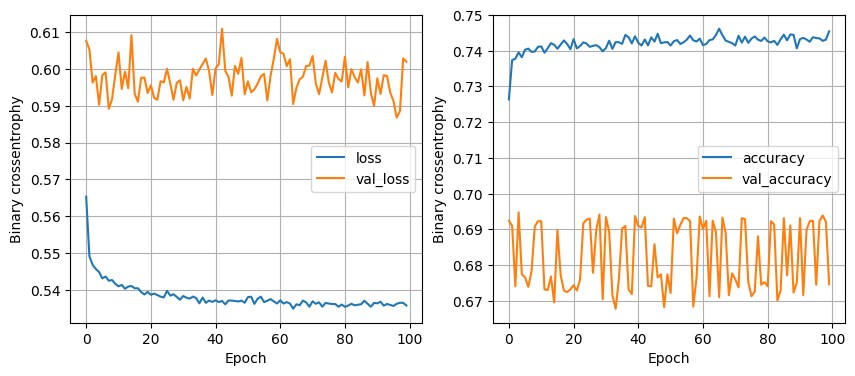

1072/1072 [==============================] - 2s 2ms/step - loss: 0.5465 - accuracy: 0.7308
8 nodes, dropout 0, lr 0.01, batch size 64, epochs=100
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 352       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 433
Trainable params: 433


KeyboardInterrupt: ignored

In [ ]:
# set up and run model predictions
epochs = 100
filepath = 'deep-learning-challenge/checkpoints/EXTRA_AlphabetSoupCharity.h5'

# view the loss and accuracy of model
least_val_loss = float('inf')
least_loss_model = None

for node in [8, 16, 24]:
  for dropout_probability in [0, 0.2]:
    for learning_rate in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f'{node} nodes, dropout {dropout_probability}, lr {learning_rate}, batch size {batch_size}, epochs={epochs}')
        nn, history = train_model(X_train, y_train, node, dropout_probability, learning_rate, batch_size, epochs)
        loss_acc = nn.evaluate(X_valid, y_valid)
        a_score = loss_acc[1]
        l_score = loss_acc[0]
        plot_history(history, a_score, l_score, node, dropout_probability, learning_rate, batch_size, epochs)
        if l_score < least_val_loss:
          least_val_loss = l_score
          least_loss_model = nn
          tf.keras.saving.save_model(
          nn, filepath, overwrite=True, save_format=None)
          

In [ ]:
# Calculate the classification report
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)

In [ ]:
target_names = ["Not Successful", "Successful"]
print(classification_report(y_test, y_pred, target_names=target_names))